In [20]:
!ls /media/inferics/DataSets/Public_Datasets/JTA-Dataset/

coco_style_convert.py  LICENSE.md	      pose.py		to_poses.py
download_data.sh       new_annotation	      __pycache__	venv
images		       new_image_annotations  README.md		videos
joint.py	       old_annotations	      requirements.txt	visualize.py
jta_banner.jpg	       old_image_annotations  to_imgs.py


In [21]:
import sys
import os

import tensorflow as tf
import numpy as np
import pathlib
import matplotlib.pyplot as plt



In [22]:
image_path = pathlib.Path("/media/inferics/DataSets/Public_Datasets/JTA-Dataset/images")
ANNO_PATH = tf.constant("/media/inferics/DataSets/Public_Datasets/JTA-Dataset/new_image_annotations")

image_ds = tf.data.Dataset.list_files(str(image_path/'train/*/*')).shuffle(10000)

for f in image_ds.take(5):
    print(f.numpy())


b'/media/inferics/DataSets/Public_Datasets/JTA-Dataset/images/train/seq_143/203.jpg'
b'/media/inferics/DataSets/Public_Datasets/JTA-Dataset/images/train/seq_127/519.jpg'
b'/media/inferics/DataSets/Public_Datasets/JTA-Dataset/images/train/seq_135/181.jpg'
b'/media/inferics/DataSets/Public_Datasets/JTA-Dataset/images/train/seq_118/881.jpg'
b'/media/inferics/DataSets/Public_Datasets/JTA-Dataset/images/train/seq_202/400.jpg'


In [23]:
def to_cam_space(joint):
    cam_transform = tf.constant([[1158,0,960],[0,1158,540],[0,0,1]], dtype=tf.float32)
    joint_homog = tf.linalg.matvec(cam_transform, joint)
    cam_space_joint = joint_homog / joint_homog[2]
    return cam_space_joint

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(len(image_batch)):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        poses = label_batch[n]
        for pose in poses:
            for joint in pose:
                text = f"[{joint[0]},{joint[1]}]"
                print(text)
                cam_space_joint = to_cam_space(joint)
                plt.text(cam_space_joint[0],cam_space_joint[1], text)
        plt.axis('off')

def get_annotation_path(img_path):
    # convert the path to a list of path components
    parts = tf.strings.split(img_path, os.path.sep)
    data_split = parts[-3]
    seq = parts[-2]
    img_name = parts[-1]

    anno_name = tf.strings.split(img_name, '.')[0] + '.npy'
    anno_path = tf.strings.join([ANNO_PATH,data_split,seq,anno_name], separator='/')
    # The second to last is the class-directory
    return anno_path

def get_annotation(anno_path):
    poses = np.load(anno_path, allow_pickle=True)
    annos = np.empty([len(poses),15,3], dtype=np.float32)
    for i, pose in enumerate(poses):
        annos[i,0,0] = pose[0].x3d #TODO ortne richtige gliedmaßen zu
        annos[i,0,1] = pose[0].y3d
        annos[i,0,2] = pose[0].z3d

        annos[i,1,0] = pose[1].x3d
        annos[i,1,1] = pose[1].y3d
        annos[i,1,2] = pose[1].z3d

        annos[i,2,0] = pose[2].x3d
        annos[i,2,1] = pose[2].y3d
        annos[i,2,2] = pose[2].z3d

        annos[i,3,0] = pose[3].x3d
        annos[i,3,1] = pose[3].y3d
        annos[i,3,2] = pose[3].z3d

        annos[i,4,0] = pose[4].x3d
        annos[i,4,1] = pose[4].y3d
        annos[i,4,2] = pose[4].z3d

        annos[i,5,0] = pose[5].x3d
        annos[i,5,1] = pose[5].y3d
        annos[i,5,2] = pose[5].z3d

        annos[i,6,0] = pose[6].x3d
        annos[i,6,1] = pose[6].y3d
        annos[i,6,2] = pose[6].z3d

        annos[i,7,0] = pose[7].x3d
        annos[i,7,1] = pose[7].y3d
        annos[i,7,2] = pose[7].z3d

        annos[i,8,0] = pose[8].x3d
        annos[i,8,1] = pose[8].y3d
        annos[i,8,2] = pose[8].z3d

        annos[i,9,0] = pose[9].x3d
        annos[i,9,1] = pose[9].y3d
        annos[i,9,2] = pose[9].z3d

        annos[i,10,0] = pose[10].x3d
        annos[i,10,1] = pose[10].y3d
        annos[i,10,2] = pose[10].z3d

        annos[i,11,0] = pose[11].x3d
        annos[i,11,1] = pose[11].y3d
        annos[i,11,2] = pose[11].z3d

        annos[i,12,0] = pose[12].x3d
        annos[i,12,1] = pose[12].y3d
        annos[i,12,2] = pose[12].z3d

        annos[i,13,0] = pose[13].x3d
        annos[i,13,1] = pose[13].y3d
        annos[i,13,2] = pose[13].z3d

        annos[i,14,0] = pose[14].x3d
        annos[i,14,1] = pose[14].y3d
        annos[i,14,2] = pose[14].z3d

    return annos

def process_path(file_path):
    anno_path = get_annotation_path(file_path)
    anno = tf.numpy_function(get_annotation, [anno_path], tf.float32)
    anno.set_shape([None,15,3])

    return file_path, anno


In [24]:
import ShAReD_Net.data.load.dataset_jta.joint as joint
import ShAReD_Net.data.load.dataset_jta.pose as pose
sys.modules['joint'] = joint
sys.modules['pose'] = pose

In [25]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = image_ds.map(process_path,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [26]:
def person_pos_from_pose(path, poses):
    poss = tf.reduce_mean(poses, axis=-2)
    return path, poss, poses

In [27]:
pos_pose_ds = labeled_ds.map(person_pos_from_pose)

In [28]:
#@tf.function
def poss_and_poses_to_img(path, poss, poses):
    poss_img = poss_to_img(poss)
    poses_img = poses_to_img(poses)

    return path, poss_img, poses_img

def poss_to_img(poss):
    cam_transform = tf.constant([[1158,0,960],[0,1158,540],[0,0,1]], dtype=tf.float32)
    poss_homog = tf.linalg.matvec(cam_transform, poss)
    poss_img = poss_homog / poss_homog[:,None,-1]
    return tf.concat([poss_img[:,:-1],poss[:,None,-1]], axis=-1)

def poses_to_img(poses):
    cam_transform = tf.constant([[1158,0,960],[0,1158,540],[0,0,1]], dtype=tf.float32)
    poses_homog = tf.linalg.matvec(cam_transform, poses)
    poses_img = poses_homog / poses_homog[:,:,None,-1]
    return tf.concat([poses_img[:,:,:-1],poses[:,:,None,-1]], axis=-1)


In [29]:
cam_ds = pos_pose_ds.map(poss_and_poses_to_img)

In [30]:

def poss_and_poses_to_cut(cut_dist, upscaling, cam_intr_f):
    def to_cut(path, poss, poses):
        poss_cut = poss_to_cut(poss, cut_dist, upscaling, cam_intr_f)
        poses_cut = poses_to_cut(poses, cut_dist, upscaling, cam_intr_f)
        return path, poss_cut, poses_cut
    return to_cut

def poss_to_cut(poss, dist, upscaling, cam_intr_f):
    poss_cut = poss * upscaling * dist / cam_intr_f
    return tf.concat([poss_cut[:,:-1],poss[:,None,-1]], axis=-1)

def poses_to_cut(poses, dist, upscaling, cam_intr_f):
    poses_cut = poses * upscaling * dist / cam_intr_f
    return tf.concat([poses_cut[:,:,:-1],poses[:,:,None,-1]], axis=-1)


In [31]:
cut_ds = cam_ds.map(poss_and_poses_to_cut(cut_dist=8, upscaling=50, cam_intr_f = 1158))


In [32]:
#TODO TEST VALIDATION to singel item datasets
def to_poss(path, poss, poses):
    return poss


poss_ds = cut_ds.map(to_poss).take(5000)
poss_ds = poss_ds.flat_map(lambda x: tf.data.Dataset.from_tensor_slices(x))

In [33]:
import tensorflow_datasets as tfds
import pandas as pd

max_pos = poss_ds.reduce(0.,tf.maximum)
min_pos = poss_ds.reduce(0.,tf.minimum)
sum_pos = poss_ds.reduce(0.,lambda x, y: x + y)
mean_pos = sum_pos / 1000


In [34]:
print(max_pos)
print(min_pos)
print(mean_pos)

tf.Tensor([1174.8927   633.009     99.67601], shape=(3,), dtype=float32)
tf.Tensor([-6.2364502e+02 -3.0662225e+02 -4.4000000e-01], shape=(3,), dtype=float32)
tf.Tensor([37696.758  15361.716   3408.3003], shape=(3,), dtype=float32)


In [35]:
numpy_data = tfds.as_numpy(poss_ds)
poss_df = pd.DataFrame(data=numpy_data, columns=["x", "y", "z"])

In [36]:
poss_df.head

<bound method NDFrame.head of                  x           y          z
0       360.008789  120.002998  21.096668
1       300.451935  160.481796  13.104667
2       171.932465  152.303940  26.156670
3       244.597015  156.751114  15.842000
4       564.654175   72.868828  29.512665
...            ...         ...        ...
113767  295.706055  292.762115   3.818000
113768  183.136978  192.218002   4.921334
113769   -9.658221  189.341110  10.523999
113770   98.456413  187.326233  15.376665
113771  145.337540  189.977921   8.040000

[113772 rows x 3 columns]>

(array([ 3267.,  9857., 13139., 13420., 13337., 11434., 10339.,  8619.,
         7146.,  5322.,  4382.,  3204.,  3055.,  2889.,  1659.,   940.,
          797.,   476.,   328.,   162.]),
 array([-0.28199998,  4.73173305,  9.74546607, 14.7591991 , 19.77293212,
        24.78666515, 29.80039817, 34.8141312 , 39.82786422, 44.84159725,
        49.85533027, 54.8690633 , 59.88279632, 64.89652935, 69.91026237,
        74.9239954 , 79.93772842, 84.95146145, 89.96519447, 94.9789275 ,
        99.99266052]),
 <a list of 20 Patch objects>)

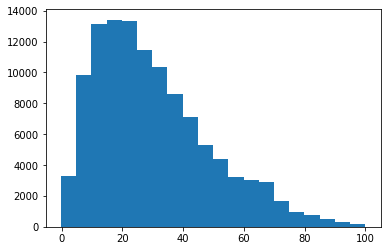

In [37]:
plt.hist(poss_df.z, bins=20)


In [38]:
poss_df.describe()


,x,y,z
count,113772.000000,113772.000000,113772.000000
mean,334.513635,136.999053,30.201217
std,142.624331,72.742925,18.881360
min,-650.899902,-175.151245,-0.282000
25%,250.461781,80.174276,15.590667
50%,333.925674,152.619331,26.371334
75%,417.133102,187.471378,41.014001
max,993.413635,1536.002075,99.992661
